In [5]:
import pandas as pd
import zipfile

# Unzip the file you uploaded
with zipfile.ZipFile("/content/IMDB Dataset.csv.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/imdb_data")

# Load the CSV
data = pd.read_csv("/content/imdb_data/IMDB Dataset.csv")
data.head()


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [6]:
import re
import string

# Basic text cleaning
def clean_text(text):
    text = text.lower()
    text = re.sub(r"<.*?>", "", text)  # remove HTML
    text = re.sub(r"[^a-zA-Z']", " ", text)  # remove non-letters
    text = re.sub(r'\s+', ' ', text)  # remove extra spaces
    return text.strip()

data['clean_review'] = data['review'].apply(clean_text)
data['sentiment'] = data['sentiment'].map({'positive': 1, 'negative': 0})  # binary label
data.head()


,review,sentiment,clean_review
0,One of the other reviewers has mentioned that ...,1,one of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...,1,a wonderful little production the filming tech...
2,I thought this was a wonderful way to spend ti...,1,i thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...,0,basically there's a family where a little boy ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,petter mattei's love in the time of money is a...


In [7]:
# Use smaller data for fast training (optional)
data = data.sample(10000, random_state=42).reset_index(drop=True)


In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# Parameters
vocab_size = 10000
max_len = 200

# Tokenization
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(data['clean_review'])

sequences = tokenizer.texts_to_sequences(data['clean_review'])
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')

# Labels
labels = data['sentiment'].values

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)


In [9]:
max_words = 10000   # or set it to the vocab size you want
max_len = 100       # or whatever sequence length you're using


In [10]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional

model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# 🛠️ COMPILE the model — this is mandatory
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# 🧱 (Optional) Build the model manually to fix summary warning
model.build(input_shape=(None, max_len))
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,378,945 (5.26 MB)

 Trainable params: 1,378,945 (5.26 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Step 4: Compile the model (add this before model.fit if you haven't)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Step 4: Fit the model (your line)
history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))



Epoch 1/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 68s 511ms/step - accuracy: 0.9433 - loss: 0.1712 - val_accuracy: 0.8390 - val_loss: 0.4112
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 87s 555ms/step - accuracy: 0.9735 - loss: 0.0950 - val_accuracy: 0.8320 - val_loss: 0.4531
Epoch 3/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 78s 520ms/step - accuracy: 0.9689 - loss: 0.0962 - val_accuracy: 0.8415 - val_loss: 0.5543
Epoch 4/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 84s 532ms/step - accuracy: 0.9909 - loss: 0.0345 - val_accuracy: 0.8255 - val_loss: 0.5444
Epoch 5/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 66s 523ms/step - accuracy: 0.9609 - loss: 0.1108 - val_accuracy: 0.8285 - val_loss: 0.6504


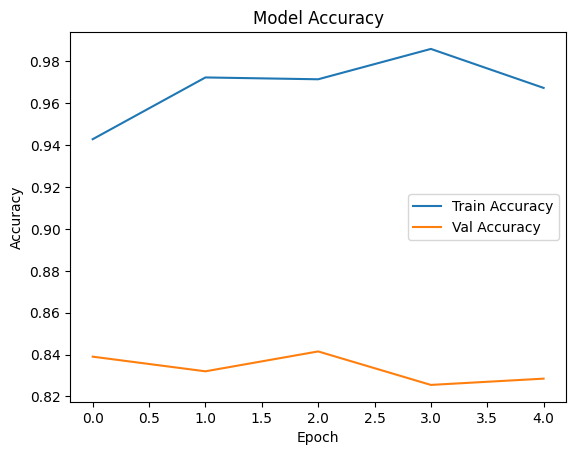

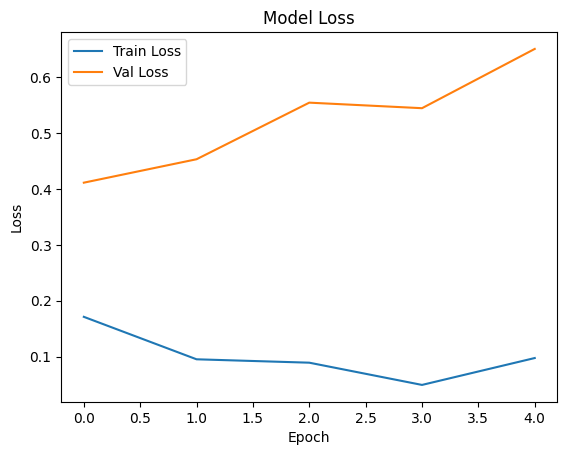

In [13]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [14]:
loss, acc = model.evaluate(X_test, y_test)
print(f"\n✅ Test Accuracy: {acc:.4f}")


63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.8338 - loss: 0.6228

✅ Test Accuracy: 0.8285


In [16]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")


63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.8338 - loss: 0.6228
Test Accuracy: 82.85%


In [15]:
def predict_review(text):
    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=max_len)
    pred = model.predict(padded)[0][0]
    print("📝 Review:", text)
    print("🧠 Sentiment:", "Positive 😊" if pred > 0.5 else "Negative 😠", f"({pred:.2f})")

predict_review("The movie was absolutely fantastic and thrilling!")
predict_review("It was a boring and terrible movie.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step
📝 Review: The movie was absolutely fantastic and thrilling!
🧠 Sentiment: Positive 😊 (0.93)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
📝 Review: It was a boring and terrible movie.
🧠 Sentiment: Negative 😠 (0.41)
